In [1]:
!pip install transformers datasets huggingface rouge_score evaluate py7zr huggingface_hub transformers[torch] --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 66.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.8/413.8 kB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.3

In [ ]:
#Load required libraries
from datasets import load_dataset
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from tqdm import tqdm
import pandas as pd
import re
import numpy as np
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
from datasets import load_metric
import evaluate
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

##2. Exploratory Data Analysis:

### (a) Conduct an initial exploration of the SAMSum dataset to gain insights into the characteristics of the dialogues and summaries.

In [ ]:
#Obtaining the Train, Test, and Validation datasets
samsum_train = load_dataset("samsum", split="train").to_pandas()
samsum_val = load_dataset("samsum", split="validation").to_pandas()
samsum_test = load_dataset("samsum", split="test").to_pandas()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


The repository for samsum contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/samsum.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

In [ ]:
#Function to clean the text
#The function replaces any non-space whitespace character and consecutive spaces with a single space
#The function removes special characters except for those in between characters of a word
#The function converts all text to lowercase

def clean_text(text):

  #Remove Whitespace character equivalent to [\r\n\t\f\v]
  text = re.sub(r'\s+', ' ', text)

  #Remove consecutive Spaces
  text = re.sub(r' +', ' ', text)

  #Remove special characters
  text = re.sub(r'(?<!\w)[^\w\s]+|[^\w\s]+(?!\w)', '', text)

  # Convert to lowercase
  text = text.lower()

  return text

In [ ]:
#Obtain number of words in each dialogue and summary of the Training Set after cleaning the text based on the 'clean_text' function
#Create a vocabulary for the summaries and dialogues in the Training Set
#Find the number of speakers in each dialogue

train_dialogue_vocab = []
train_summary_vocab = []

for i in tqdm(range(len(samsum_train))):
  speakers = []

  if '\n' in samsum_train.loc[i, 'dialogue']:
    for j in samsum_train.loc[i, 'dialogue'].split('\n'):
      speakers.append(j.split(":")[0])
  else:
    for j in samsum_train.loc[i, 'dialogue'].split('\r\n'):
      speakers.append(j.split(":")[0])

  dialogue_tokens = clean_text(samsum_train.loc[i, 'dialogue']).split(" ")
  summary_tokens = clean_text(samsum_train.loc[i, 'summary']).split(" ")

  train_dialogue_vocab.extend(dialogue_tokens)
  train_summary_vocab.extend(summary_tokens)

  samsum_train.loc[i, 'dialogue_length'] = len(dialogue_tokens)
  samsum_train.loc[i, 'summary_length'] = len(summary_tokens)
  samsum_train.loc[i, 'speaker_count'] = len(set(speakers))

samsum_train.head()

100%|██████████| 14732/14732 [00:07<00:00, 1924.79it/s]


,id,dialogue,summary,dialogue_length,summary_length,speaker_count
0,13818513,Amanda: I baked cookies. Do you want some?\r\...,Amanda baked cookies and will bring Jerry some...,16.0,9.0,2.0
1,13728867,Olivia: Who are you voting for in this electio...,Olivia and Olivier are voting for liberals in ...,18.0,11.0,2.0
2,13681000,"Tim: Hi, what's up?\r\nKim: Bad mood tbh, I wa...",Kim may try the pomodoro technique recommended...,98.0,14.0,2.0
3,13730747,"Edward: Rachel, I think I'm in ove with Bella....",Edward thinks he is in love with Bella. Rachel...,26.0,19.0,2.0
4,13728094,Sam: hey overheard rick say something\r\nSam:...,"Sam is confused, because he overheard Rick com...",179.0,27.0,2.0


In [ ]:
#Vocabulary of Dialogues and Summaries in Training Set

train_dialogue_vocab = set(train_dialogue_vocab)
train_summary_vocab = set(train_summary_vocab)

train_dialogue_vocab.remove('')
train_summary_vocab.remove('')

print("Vocabulary of Dialogues in Training Set: ", train_dialogue_vocab)
print("Length of Dialogue Vocabulary: ", len(train_dialogue_vocab))
print("Vocabulary of Summaries in Training Set: ", train_summary_vocab)
print("Length of Summary Vocabulary: ", len(train_summary_vocab))

Vocabulary of Dialogues in Training Set:  {'culture/climate/language/whatever', 'tonya', 'navigated', 'whoooooah', 'unveiled', 'occupation', 'changed', 'vinyards', 'helps', 'ruuuuuuuuuuuuuuuuuuuuude', 'krona', 'aj', 'half-way', 'april/may', 'rozas', 'tales', 'fuckers', '3-4', 'biked', 'exam', "zoe's", 'luc', 'stalking', 'bluff', 'wear', '21st', 'brochure', 'yez', 'maria', 'kathmandu', 'vosges', 'cheque', 'lupe', 'growths', 'mmmmmmhm', 'bob', 'digestif', 'recommendtion', 'ludo', 'kittie', 'stewardess', '1060', 'gen', 'referee', 'xstore', 'wardrobe', 'yesssss', 'waiving', 'cutest', 'competition', 'tall', 'recalculated', 'jordans', 'rationalization', 'klementine', 'uncontrollable', 'nativity', 'scobs', "joan's", 'rue', 'therese', 'scheduling', 'curtains', 'rightist', 'commissioned', 'ine', 'whazaaaap', 'convey', 'butterflies', 'yet;d', 'compares', 'quays', 'somehow:d', 'andromeda', 'determine', 'khan', 'extinct', "pain's", 'religion', 'mary’s', 'income', 'snad', 'knocks', 'side-swept', 'c

In [ ]:
#There are words in the summary that are not in the dialogues
train_summary_vocab.difference(train_dialogue_vocab)

{'affleck',
 'self-assessment',
 'appoinment',
 'gived',
 'departs',
 "sandy's",
 'książę',
 "aj's",
 "jonah's",
 "elsie's",
 'gdańsk',
 'deactivated',
 "mcr's",
 'mamon',
 'grating',
 'milions',
 "lang's",
 'tyles',
 'britanny',
 "marc's",
 "faby's",
 "reine's",
 'angrier',
 "tero's",
 'defends',
 'becuse',
 "smith's",
 "tailor's",
 'baloon',
 'para',
 "ariel's",
 'unrecognisable',
 "al's",
 'freedoms',
 "amie's",
 '1-hour',
 "dayton's",
 'micahael',
 "trinity's",
 'mid-october',
 "nando's",
 "leticia's",
 "yasmine's",
 "marylin's",
 'angeles',
 "brigitte's",
 "owner's",
 'unify',
 'reintroducing',
 "bolesław's",
 'ultimately',
 'issuing',
 'mon-sat',
 "dale's",
 'borrows',
 "gentelmen's",
 'perpetrator',
 "gallo's",
 "podsiadlo's",
 "granny's",
 'connects',
 'messenger-like',
 "former's",
 "angella's",
 'reconnaissance',
 'disregarding',
 "anote's",
 'simulating',
 'tessa’s',
 "keegan's",
 "parker's",
 "aliyah's",
 'editable',
 "lena's",
 'lessen',
 'narcosthemed',
 "linn's",
 'forgi

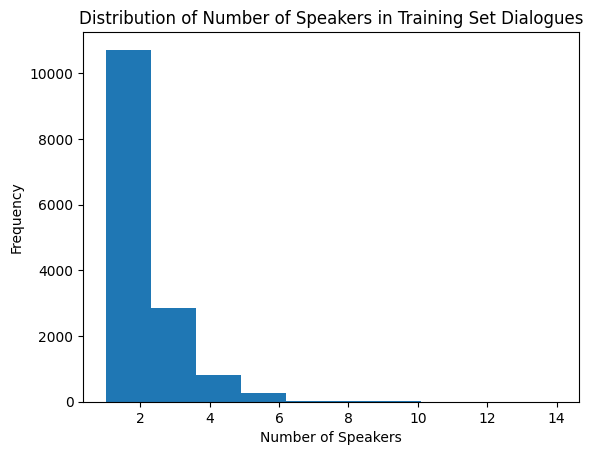

In [ ]:
#Distribution of the Number of Speakers in the Training Set Dialogues

plt.hist(samsum_train['speaker_count'], bins = 10)
plt.xlabel('Number of Speakers')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Speakers in Training Set Dialogues')
plt.show()

In [ ]:
#Obtain number of words in each dialogue and summary of the Validation Set after cleaning the text based on the 'clean_text' function
#Create a vocabulary for the summaries and dialogues in the Validation Set
#Find the number of speakers in each dialogue

val_dialogue_vocab = []
val_summary_vocab = []

for i in tqdm(range(len(samsum_val))):
  speakers = []

  if '\n' in samsum_val.loc[i, 'dialogue']:
    for j in samsum_val.loc[i, 'dialogue'].split('\n'):
      speakers.append(j.split(":")[0])
  else:
    for j in samsum_val.loc[i, 'dialogue'].split('\r\n'):
      speakers.append(j.split(":")[0])

  dialogue_tokens = clean_text(samsum_val.loc[i, 'dialogue']).split(" ")
  summary_tokens = clean_text(samsum_val.loc[i, 'summary']).split(" ")

  val_dialogue_vocab.extend(dialogue_tokens)
  val_summary_vocab.extend(summary_tokens)

  samsum_val.loc[i, 'dialogue_length'] = len(dialogue_tokens)
  samsum_val.loc[i, 'summary_length'] = len(summary_tokens)
  samsum_val.loc[i, 'speaker_count'] = len(set(speakers))

samsum_val.head()

100%|██████████| 818/818 [00:00<00:00, 2114.69it/s]


,id,dialogue,summary,dialogue_length,summary_length,speaker_count
0,13817023,"A: Hi Tom, are you busy tomorrow’s afternoon?\...",A will go to the animal shelter tomorrow to ge...,170.0,29.0,2.0
1,13716628,Emma: I’ve just fallen in love with this adven...,Emma and Rob love the advent calendar. Lauren ...,176.0,29.0,3.0
2,13829420,Jackie: Madison is pregnant\r\nJackie: but she...,Madison is pregnant but she doesn't want to ta...,165.0,22.0,2.0
3,13819648,Marla: <file_photo>\r\nMarla: look what I foun...,Marla found a pair of boxers under her bed.,188.0,9.0,3.0
4,13728448,Robert: Hey give me the address of this music ...,Robert wants Fred to send him the address of t...,34.0,19.0,2.0


In [ ]:
#Vocabulary of Dialogues and Summaries in Validation Set

val_dialogue_vocab = set(val_dialogue_vocab)
val_summary_vocab = set(val_summary_vocab)

val_dialogue_vocab.remove('')
val_summary_vocab.remove('')

print("Vocabulary of Dialogues in Validation Set: ", val_dialogue_vocab)
print("Length of Dialogue Vocabulary: ", len(val_dialogue_vocab))
print("Vocabulary of Summaries in Validation Set: ", val_summary_vocab)
print("Length of Summary Vocabulary: ", len(val_summary_vocab))

Vocabulary of Dialogues in Validation Set:  {'lana', 'hopefully', 'stanley', 'eyebrow', 'changed', 'helps', 'ya', 'aj', 'forgot', 'theatre', 'brenda', 'origin', 'kissing', 'publishing', 'fuckers', 'exam', 'rowing', 'i', 'grass', 'wear', '21st', 'basia', 'fefe', 'returned', 'brochure', 'yeeeeyyyyy', 'httpsnosteam', 'unbelievable', 'holy', 'maria', 'washing-up', '20th', 'tough', 'bob', 'marketing', 'np', 'vanilla', 'june', 'standard', 'gap', 'hour', 'appear', 'against', 'b', 'wardrobe', 'installations', 'tall', 'content', 'music', 'godddd', 'tom', 'theirs', 'visa', 'scheduling', 'curtains', 'saves', 'written', 'motor', 'indoors', 'batshit', 'snitch', 'convey', 'm8', 'catherine', 'xiao', 'towels', 'joey', 'conrad', 'stressed', 'income', 'splendid', 'shops', 'aiport', 'logan', 'regretted', 'cleaner', 'crease', 'purpose', 'reggie', 'rudolph', 'took', 'researcher', '1st', 'uncle', 'exhausted', 'kill', 'feed', 'tania', 'pub', 'gabe', 'russel', 'juan', 'work', 'allen', 'running', 'websites', '

In [ ]:
#There are words in the Validation Set Summary Vocabulary that are not in the Validation Set Dialogue Vocabulary
val_summary_vocab.difference(val_dialogue_vocab)

{'1000km',
 '10th',
 '12.00',
 '1500',
 '2-2:30',
 '20-25',
 '20-30mins',
 '3.00',
 '3:30',
 '4.30',
 '40th',
 '5:20',
 '8.00',
 '8.30',
 'accidentally',
 'accommodative',
 'accompanied',
 "adam's",
 "adele's",
 "adrian's",
 "adrien's",
 'advantages',
 'agrees',
 'agressive',
 'airs',
 "alan's",
 "alex's",
 "alice's",
 "allan's",
 "amanda's",
 "andrew's",
 "angela's",
 "ann's",
 "anne's",
 'announces',
 'annoyed',
 'annoys',
 "anton's",
 'apologises',
 'appears',
 'appreciates',
 'approx',
 "arnold's",
 'assist',
 'associated',
 'attended',
 'attends',
 'attractive',
 'balthus',
 "beata's",
 "beatrix's",
 'beause',
 'becoming',
 'behavior',
 'belarus',
 'believes',
 'belongs',
 "bev's",
 'bite',
 'blames',
 'borke',
 'borrowing',
 "boss's",
 'boundaries',
 'breasts',
 "brian's",
 "bridget's",
 "broke's",
 'brows',
 'bug',
 'burden',
 "callum's",
 "camil's",
 "carla's",
 "carmen's",
 'casole',
 "casper's",
 'celebrated',
 'cemetery',
 "charlie's",
 'cheating',
 "cheryl's",
 'chili',
 "c

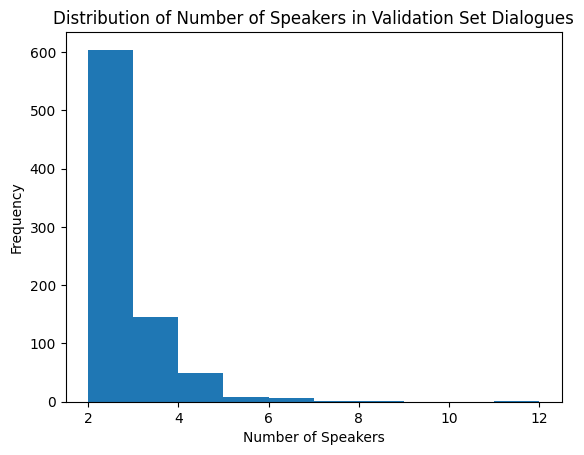

In [ ]:
#Distribution of the Number of Speakers in the Validation Set Dialogues

plt.hist(samsum_val['speaker_count'], bins = 10)
plt.xlabel('Number of Speakers')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Speakers in Validation Set Dialogues')
plt.show()

In [ ]:
#Obtain number of words in each dialogue and summary of the Test Set after cleaning the text based on the 'clean_text' function
#Create a vocabulary for the summaries and dialogues in the Test Set
#Find the number of speakers in each dialogue

test_dialogue_vocab = []
test_summary_vocab = []

for i in tqdm(range(len(samsum_test))):
  speakers = []

  if '\n' in samsum_test.loc[i, 'dialogue']:
    for j in samsum_test.loc[i, 'dialogue'].split('\n'):
      speakers.append(j.split(":")[0])
  else:
    for j in samsum_test.loc[i, 'dialogue'].split('\r\n'):
      speakers.append(j.split(":")[0])

  dialogue_tokens = clean_text(samsum_test.loc[i, 'dialogue']).split(" ")
  summary_tokens = clean_text(samsum_test.loc[i, 'summary']).split(" ")

  test_dialogue_vocab.extend(dialogue_tokens)
  test_summary_vocab.extend(summary_tokens)

  samsum_test.loc[i, 'dialogue_length'] = len(dialogue_tokens)
  samsum_test.loc[i, 'summary_length'] = len(summary_tokens)
  samsum_test.loc[i, 'speaker_count'] = len(set(speakers))

samsum_test.head()

100%|██████████| 819/819 [00:00<00:00, 1999.59it/s]


,id,dialogue,summary,dialogue_length,summary_length,speaker_count
0,13862856,"Hannah: Hey, do you have Betty's number?\nAman...",Hannah needs Betty's number but Amanda doesn't...,71.0,14.0,2.0
1,13729565,Eric: MACHINE!\r\nRob: That's so gr8!\r\nEric:...,Eric and Rob are going to watch a stand-up on ...,82.0,11.0,2.0
2,13680171,"Lenny: Babe, can you help me with something?\r...",Lenny can't decide which trousers to buy. Bob ...,106.0,27.0,2.0
3,13729438,"Will: hey babe, what do you want for dinner to...",Emma will be home soon and she will let Will k...,86.0,11.0,2.0
4,13828600,"Ollie: Hi , are you in Warsaw\r\nJane: yes, ju...",Jane is in Warsaw. Ollie and Jane has a party....,207.0,42.0,2.0


In [ ]:
#Vocabulary of Dialogues and Summaries in Test Set

test_dialogue_vocab = set(test_dialogue_vocab)
test_summary_vocab = set(test_summary_vocab)

test_dialogue_vocab.remove('')
test_summary_vocab.remove('')

print("Vocabulary of Dialogues in Test Set: ", test_dialogue_vocab)
print("Length of Dialogue Vocabulary: ", len(test_dialogue_vocab))
print("Vocabulary of Summaries in Test Set: ", test_summary_vocab)
print("Length of Summary Vocabulary: ", len(test_summary_vocab))

Vocabulary of Dialogues in Test Set:  {'hopefully', 'stanley', 'changed', 'myah', 'reccomend', 'fiasco', 'belongs', 'helps', 'ya', 'companionship', 'forgot', 'theatre', 'brenda', 'origin', 'kissing', '3-4', 'exam', 'cured', 'i', 'wear', '21st', 'returned', 'persistence', 'unbelievable', 'holy', 'self-organised', 'maria', 't', '20th', 'vosges', 'tough', 'bob', 'ludo', 'np', 'vanilla', 'frann', 'bodyguard', 'june', 'meow', 'standard', 'angeles', 'hour', 'shove', 'appear', 'against', 'marginalized', 'oval', 'b', 'kohaku', 'wardrobe', 'yesssss', 'aviana', 'cutest', 'carlos', 'tall', 'filmsｖ', 'content', 'godddd', 'music', 'tom', 'mints', 'holding', 'migration', 'fancied', 'magician', 'written', 'butterflies', 'numb', 'nathalie', 'catherine', 'determine', 'conrad', 'stressed', 'splendid', 'shops', 'expense', 'compiling', 'logan', 'pronounce', 'chloes', 'purpose', 'reggie', 'yeeeepit', 'lied', 'took', '1st', 'uncle', 'exchanges', 'exhausted', 'partly', 'refill', 'kill', '7-8', 'feed', 'well-

In [ ]:
#There are words in the Test Set Summary Vocabulary that are not in the Test Set Dialogue Vocabulary
test_summary_vocab.difference(test_dialogue_vocab)

{'158',
 '19:30',
 '2:22',
 '300',
 '3:24',
 '4-wheel',
 '4pm',
 '5-year-old',
 '5:24',
 '6123',
 'abdominal',
 'abilities',
 'absence',
 'accepts',
 'accomodate',
 'according',
 "adele's",
 'adviced',
 'advise',
 'advised',
 'advises',
 'affected',
 'afterparty',
 'agrees',
 'agressive',
 'alarm',
 'alcohol',
 "aldo's",
 "alex's",
 "alice's",
 "alicja's",
 'ambivalent',
 "andrea's",
 "andrew's",
 "angie's",
 "anne's",
 'annoyed',
 'anti-immigration',
 "antonio's",
 'apologise',
 'apologizes',
 'appreciative',
 'appropriate',
 'arrival',
 'artist',
 'assemble',
 'attacker',
 'attending',
 'attractive',
 "aubrianna's",
 'aura',
 'avenue',
 'babysitting',
 "barbara's",
 'barbeque',
 'barley',
 'barman',
 "battery's",
 'beforehand',
 "belchen's",
 "benjamin's",
 "benson's",
 "beyonce's",
 "bez's",
 "birthday's",
 'blamed',
 "bob's",
 "bobby's",
 "booker's",
 'bookshop',
 "boyfriend's",
 "brad's",
 "brett's",
 'brings',
 'buses',
 'buys',
 "cafe's",
 'cal',
 "callan's",
 'canceled',
 "cell

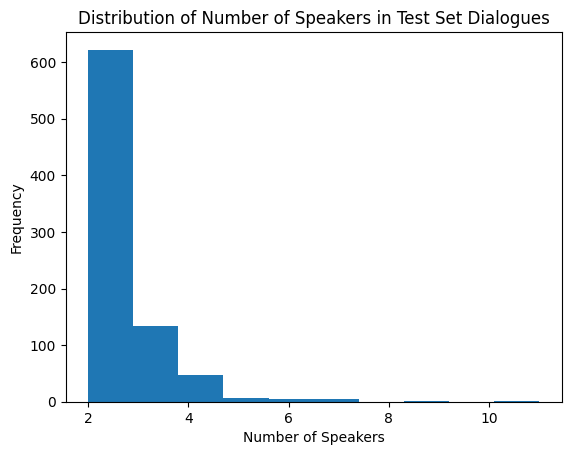

In [ ]:
#Distribution of the Number of Speakers in the Test Set Dialogues

plt.hist(samsum_test['speaker_count'], bins = 10)
plt.xlabel('Number of Speakers')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Speakers in Test Set Dialogues')
plt.show()

### (b) Plot the length distribution of dialogues and summaries in the training set.

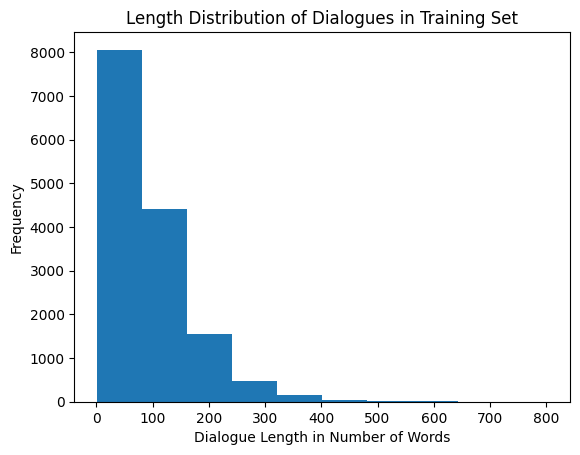

In [ ]:
#Length Distribution of Dialogues in the Training Set
plt.hist(samsum_train['dialogue_length'], bins = 10)
plt.xlabel('Dialogue Length in Number of Words')
plt.ylabel('Frequency')
plt.title('Length Distribution of Dialogues in Training Set')
plt.show()

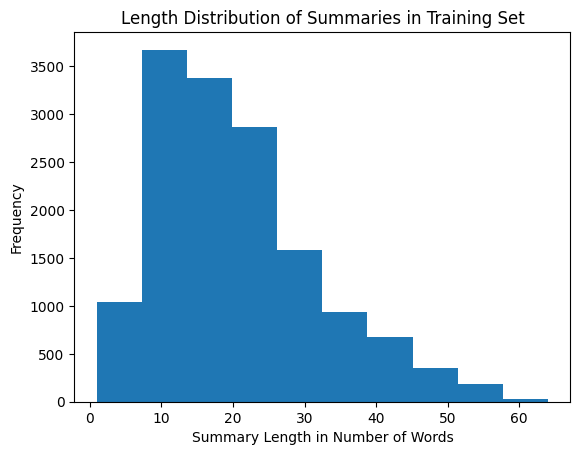

In [ ]:
#Length Distribution of Summaries in the Training Set
plt.hist(samsum_train['summary_length'], bins = 10)
plt.xlabel('Summary Length in Number of Words')
plt.ylabel('Frequency')
plt.title('Length Distribution of Summaries in Training Set')
plt.show()

### (c) Display the 20 most common words in the dialogues and their frequencies.

In [ ]:
train_dialogue_vocab_dict = {}
train_summary_vocab_dict = {}

for i in tqdm(range(len(samsum_train))):

  dialogue_tokens = clean_text(samsum_train.loc[i, 'dialogue']).split(" ")
  summary_tokens = clean_text(samsum_train.loc[i, 'summary']).split(" ")

  for j in dialogue_tokens:
    if j == '':
      continue
    if j in train_dialogue_vocab_dict:
      train_dialogue_vocab_dict[j] += 1
    else:
      train_dialogue_vocab_dict[j] = 1

  for j in summary_tokens:
    if j == '':
      continue
    if j in train_summary_vocab_dict:
      train_summary_vocab_dict[j] += 1
    else:
      train_summary_vocab_dict[j] = 1

100%|██████████| 14732/14732 [00:02<00:00, 5547.47it/s]


In [ ]:
print("20 Most common Words in Dialogues: ", dict(sorted(train_dialogue_vocab_dict.items(), reverse = True, key = lambda x: x[1])[:20]))
print("20 Most common Words in Summaries: ", dict(sorted(train_summary_vocab_dict.items(), reverse = True, key = lambda x: x[1])[:20]))

20 Most common Words in Dialogues:  {'i': 44149, 'you': 39077, 'the': 31569, 'to': 29204, 'a': 22259, 'it': 20404, 'and': 17728, 'for': 11987, 'in': 11563, 'is': 11338, 'that': 10884, 'have': 10781, 'of': 10770, 'so': 10481, 'but': 10197, 'me': 10182, 'be': 9173, 'what': 8676, 'we': 8642, 'are': 8457}
20 Most common Words in Summaries:  {'to': 11612, 'the': 10749, 'and': 10144, 'a': 7446, 'is': 6850, 'will': 6743, 'for': 4678, 'in': 4155, 'at': 3714, 'her': 3609, 'on': 2994, 'she': 2991, 'with': 2764, 'he': 2698, 'of': 2518, 'has': 2512, 'it': 2320, 'are': 2319, 'his': 2186, 'they': 1917}


## 3. Inference with Pre-trained Models:

### (a) Choose at least three pre-trained summarization models from the Hugging Face model hub, such as facebook/bart-large-cnn or t5-large.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
#Choose 3 pre-trained summarization models and their respective tokenizers
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForCausalLM

bart_model = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-large-cnn").to(device)
t5_model = AutoModelForSeq2SeqLM.from_pretrained("google-t5/t5-small").to(device)
pegasus_model = AutoModelForSeq2SeqLM.from_pretrained("google/pegasus-xsum").to(device)

bart_tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-cnn")
t5_tokenizer = AutoTokenizer.from_pretrained("google-t5/t5-small")
pegasus_tokenizer = AutoTokenizer.from_pretrained("google/pegasus-xsum")

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/259 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/87.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.52M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

### (b) Use the models to generate summaries for a few randomly selected dialogues. Analyze the quality of these summaries: Are they coherent? Do they capture the essential points in the conversation?

In [ ]:
#Select 10 Random Sentences from SAMsum Training Set
import random

random.seed(100)

random_indices = [random.randint(0, len(samsum_train)) for _ in range(10)]

random_sentences = [samsum_train.loc[i, 'dialogue'] for i in random_indices]
random_sentences

["Dave: Plz give me 5 music artists you like.\r\nNick: Not sure why u need it but kk\r\nNick: 1.) Metallica 2.) Glitch Mob 3.) Eminem 4.) Snoop Dogg 5.) The Black Keys\r\nNick: What's up with it?\r\nDave: I'm trying to configure my youtube autoplay so it can be more similiar to yours.\r\nNick: Hahaha. I doubt if works as you want it. But ok.\r\nNick: I'm flattered.\r\nDave: I know what I'm doin\r\nNick: No doubt :D",
 'Bobby: could you buy me soy milk on your way home?\nGalina: too late\nSiena: I can buy you soy milk. Anything else?\nGalina: buy some bread too\nBobby: thx\nSiena: k',
 "Nelly: Thanks again! You've saved me from madness :-)\r\nGina: :-) Glad to be of assistance\r\nNelly: <file_photo>\r\nGina: Thank you!",
 'Margaret: Hey there! What r u doing for your 30th birthday?\r\nMargaret: It’s coming up soon?!\r\nJenny: I’m going to break up with John 😉\r\nMargaret: No, u can’t! U seem to be like an institution\r\nJenny: That’s my point 😉 I was just thinking of exciting ways to ch

In [ ]:
#Generating Summaries using BART
bart_summaries = []

tokenized_sentences = bart_tokenizer(random_sentences, truncation = True, padding = True, return_tensors = 'pt').to(device)

with torch.no_grad():
  bart_outputs = bart_model.generate(**tokenized_sentences)

bart_summaries = bart_tokenizer.batch_decode(bart_outputs, skip_special_tokens = True)

bart_summaries

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


["Dave: Plz give me 5 music artists you like. Metallica 2.) Glitch Mob 3.) Eminem 4.) Snoop Dogg 5.) The Black Keys. I'm trying to configure my youtube autoplay so it can be more similiar to yours. I doubt if works as you want it.",
 'Bobby: could you buy me soy milk on your way home? Galina: too late. Siena: I can buy you soy milk. Anything else?Galina: buy some bread too. Bobby: thx.Siena, k.',
 "Nelly: Thanks again! You've saved me from madness. Gina: :-) Glad to be of assistance. Nelly: <file_photo>\xa0\xa0 Gina: Thank you! Gina:\xa0Gina:\xa0I'm glad to be able to help you.",
 'Margaret: Hey there! What r u doing for your 30th birthday? Jenny: I’m going to break up with John. Margaret: No, u can’t! U seem to be like an institution. Jenny: That’s my point. I was just thinking of exciting ways to change my life.',
 "Jean: Frankie, my phone finally packed up. That's from Kuba's phone, just to let you know. I was starting to worry why you don't reply to my messages. Kuba says it's beyo

In [ ]:
#Generating Summaries using T5
t5_summaries = []

tokenized_sentences = t5_tokenizer(['summarize: ' + i for i in random_sentences], truncation = True, padding = True, return_tensors = 'pt').to(device)

#Let the max length of generated summary be the length of the summaries of 95% of the training summaries
lengths = [len(t5_tokenizer.tokenize(text)) for text in samsum_train['summary']]
max_length = int(np.percentile(lengths, 95))

with torch.no_grad():
  t5_outputs = t5_model.generate(**tokenized_sentences, max_length = max_length)

t5_summaries = t5_tokenizer.batch_decode(t5_outputs, skip_special_tokens = True)

t5_summaries

["kk Nick: I'm trying to configure my youtube autoplay so it can be more similiar to yours. Nick: I know what I'm doin.",
 'galina: could you buy me soy milk on your way home? Galina: too late Siena: could you buy me soy milk on your way home?',
 "Nelly: thanks again! You've saved me from madness.",
 'Jenny: u seem to be like an institution Jenny: u can’t!',
 "Jean: Kuba says it's beyond repair and I need a new phone.",
 'mandy: have an oculist appointment, forgot Karen. ok, another time with u after class.',
 'Lonya: I know how nasty the cold weather can be. one just cannot get used to it. I hate it too! Lonya: I do believe in medicine, with all these rapid advancements.',
 "beatrice: i'm not :( Victoria: Maybe you can still make it? beatrice: Rofl Sarah: my parents are here.(( Victoria:... :D Beatrice: Say 'hi' from me.",
 'dr Haller died in a death notice on the front door to his uni. he was like 50 or so and has been riding his bike for his whole life. he was very fit and he has be

In [ ]:
#Generating Summaries using Pegasus
pegasus_summaries = []

tokenized_sentences = pegasus_tokenizer(random_sentences, truncation = True, padding = True, return_tensors = 'pt').to(device)

#Let the max length of generated summary be the length of the summaries of 95% of the training summaries
lengths = [len(pegasus_tokenizer.tokenize(text)) for text in samsum_train['summary']]
max_length = int(np.percentile(lengths, 95))

with torch.no_grad():
  pegasus_outputs = pegasus_model.generate(**tokenized_sentences, max_length = max_length)

pegasus_summaries = pegasus_tokenizer.batch_decode(pegasus_outputs, skip_special_tokens = True)

pegasus_summaries

['Nick Grimshaw and Dave Gorman go head-to-head in a game of musical ping-pong.',
 'Galina: can you buy me soy milk on your way home?',
 'Gina: Thanks again for your kind words.',
 'Jenny: Hi Margaret!',
 'In our series of letters from African journalists, film-maker and columnist Frankie collates some of his favourite snippets from the news.',
 'Karen: can I go with you after class?',
 'Marie: Hello, Lonya.',
 'Sarah: do you want to go to the cinema?',
 "In this week's episode of The One Show, Daniel and George are talking about the death of their professor.",
 'Matt: Hi Cameron.']

Among the models chosen (BART-CNN Large, T5-Small, and PEGASUS-XSum) none of the generated summaries of the randomly selected sentences are completely coherent. Many of them maintain the same style of writing as that of the dialogue itself. Better performance can be achieved via Finetuning.

## 4. Fine-Tuning:

### (a) Choose one of the pre-trained summarization models from the previous part.

In [ ]:
t5_model = AutoModelForSeq2SeqLM.from_pretrained("google-t5/t5-small").to(device)

### (b) Preprocess the dataset to fit it to the input format required by the chosen model, which may include tokenizing the dialogues and their summaries.

In [ ]:
#Training Dialogue Text Lengths
lengths = [len(t5_tokenizer.tokenize(text)) for text in samsum_train['dialogue']]
print(f"Text lengths: {lengths}")

#Determine 95th percentile of Dialogue Lengths
max_length = int(np.percentile(lengths, 95))
print(f"95th percentile of Dialogue Lengths: {max_length}")

Token indices sequence length is longer than the specified maximum sequence length for this model (566 > 512). Running this sequence through the model will result in indexing errors


Text lengths: [27, 26, 151, 54, 268, 116, 566, 229, 79, 204, 107, 22, 37, 169, 169, 235, 74, 110, 68, 62, 380, 361, 21, 388, 66, 122, 88, 147, 166, 151, 444, 143, 45, 232, 153, 194, 172, 224, 170, 280, 290, 283, 114, 399, 261, 201, 138, 206, 80, 395, 40, 150, 45, 151, 191, 101, 338, 164, 101, 110, 190, 412, 64, 288, 43, 64, 114, 120, 162, 47, 24, 65, 142, 113, 197, 83, 255, 77, 87, 401, 571, 72, 47, 239, 147, 144, 28, 100, 177, 211, 35, 32, 92, 95, 74, 44, 230, 119, 81, 59, 270, 28, 138, 148, 316, 65, 48, 97, 91, 103, 44, 41, 107, 80, 230, 172, 163, 127, 236, 318, 406, 54, 67, 91, 166, 76, 59, 435, 146, 95, 146, 202, 100, 51, 56, 95, 103, 137, 226, 55, 91, 83, 151, 133, 62, 169, 80, 174, 57, 97, 283, 281, 209, 261, 162, 65, 181, 89, 88, 255, 118, 74, 81, 338, 143, 189, 91, 37, 117, 249, 205, 135, 70, 150, 181, 90, 41, 193, 154, 90, 168, 71, 127, 322, 52, 168, 81, 118, 110, 37, 119, 138, 198, 135, 64, 155, 111, 87, 177, 205, 114, 257, 60, 61, 77, 311, 93, 88, 62, 41, 224, 258, 85, 110, 

In [ ]:
#Training Summary Text Lengths
lengths = [len(t5_tokenizer.tokenize(text)) for text in samsum_train['summary']]
print(f"Text lengths: {lengths}")

#Determine 95th percentile of Summary Lengths
max_length = int(np.percentile(lengths, 95))
print(f"95th percentile of Summary Lengths: {max_length}")

Text lengths: [10, 13, 18, 24, 37, 37, 54, 38, 21, 52, 20, 16, 10, 24, 27, 22, 48, 19, 22, 17, 21, 73, 16, 48, 23, 27, 25, 36, 51, 15, 69, 32, 8, 13, 28, 21, 30, 46, 31, 20, 66, 33, 23, 35, 16, 19, 24, 18, 7, 48, 10, 28, 21, 23, 40, 21, 51, 58, 32, 31, 34, 48, 20, 48, 17, 7, 25, 19, 39, 16, 13, 38, 14, 33, 65, 29, 51, 19, 11, 43, 68, 23, 8, 27, 26, 14, 14, 20, 44, 24, 13, 12, 7, 21, 27, 26, 53, 22, 25, 28, 43, 12, 22, 32, 45, 28, 20, 30, 14, 14, 23, 14, 27, 21, 34, 40, 22, 19, 42, 65, 31, 36, 10, 22, 29, 8, 11, 57, 25, 21, 20, 15, 22, 17, 21, 17, 9, 68, 11, 16, 22, 8, 26, 37, 7, 42, 11, 12, 14, 33, 54, 67, 21, 45, 27, 20, 59, 20, 46, 30, 28, 17, 11, 9, 15, 38, 21, 12, 23, 25, 33, 31, 10, 32, 19, 23, 21, 24, 23, 22, 30, 18, 17, 27, 27, 20, 11, 19, 25, 10, 26, 64, 38, 32, 26, 17, 15, 22, 63, 29, 30, 24, 12, 18, 10, 54, 31, 17, 29, 16, 18, 58, 20, 31, 43, 18, 19, 22, 30, 25, 44, 19, 50, 16, 27, 42, 55, 39, 19, 23, 12, 13, 13, 30, 9, 59, 41, 10, 39, 11, 21, 48, 40, 20, 41, 19, 31, 38, 22, 

In [ ]:
#Tokenize the Dialogues and Summaries

def preprocess_function(examples):

  model_inputs = t5_tokenizer(['summarize: ' + i for i in examples['dialogue']], truncation = True)
  summaries = t5_tokenizer(examples['summary'], truncation = True)

  model_inputs['labels'] = summaries['input_ids']

  return model_inputs

In [ ]:
#Tokenize the Dataset in Batches
raw_samsum_dataset = load_dataset("samsum")
tokenized_samsum_dataset = raw_samsum_dataset.map(preprocess_function, batched = True)
tokenized_samsum_dataset = tokenized_samsum_dataset.remove_columns(['dialogue', 'summary', 'id'])
tokenized_samsum_dataset

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 818
    })
})

In [ ]:
#Setup the Data Collator
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer = t5_tokenizer, model = t5_model)

### (c) Train the model on the SAMSum corpus, monitoring its performance on the validation set, and adjust the hyperparameters as needed. (d) Employ appropriate metrics for evaluating summarization quality, such as ROUGE scores, which compare the generated summaries against the reference summaries.

In [ ]:
#Training Arguments

training_args = Seq2SeqTrainingArguments(
    output_dir = "t5-finetuned-summarization-samsum",
    eval_strategy = "epoch",
    learning_rate = 5e-5,
    lr_scheduler_type = "linear",
    per_device_train_batch_size = 8,
    per_device_eval_batch_size = 8,
    num_train_epochs = 10,
    weight_decay = 0.01,
    save_total_limit = 3,
    predict_with_generate = True,
    logging_steps = len(tokenized_samsum_dataset['train'])//8,
    push_to_hub = False,
    save_strategy = "epoch",
    load_best_model_at_end = True
)

In [ ]:
#Define Compute Metrics Function

rouge_score = evaluate.load("rouge")

def compute_metrics_rouge_scores(X):

  predictions, labels = X #X is a tuple

  decoded_predictions = t5_tokenizer.batch_decode(predictions, skip_special_tokens = True) #Get back predictions in human readable format

  labels = np.where(labels != -100, labels, t5_tokenizer.pad_token_id) #Replace the -100 with T5 Tokenizer's ID for pad token

  decoded_labels = t5_tokenizer.batch_decode(labels, skip_special_tokens = True) #Get back labels in human readable format

  #Sentences need to be separated by '\n' for ROUGE evaluation
  for i in range(len(decoded_predictions)):
    decoded_predictions[i] = '\n'.join(sent_tokenize(decoded_predictions[i].strip()))

  for i in range(len(decoded_labels)):
    decoded_labels[i] = '\n'.join(sent_tokenize(decoded_labels[i].strip()))

  rouge_scores = rouge_score.compute(predictions = decoded_predictions, references = decoded_labels)

  rouge_scores = {key: round(value * 100, 4) for key, value in rouge_scores.items()}

  return rouge_scores


In [ ]:
#Instantiate Trainer and perform training

t5_trainer = Seq2SeqTrainer(
    model = t5_model,
    args = training_args,
    train_dataset = tokenized_samsum_dataset['train'],
    eval_dataset = tokenized_samsum_dataset['validation'],
    tokenizer = t5_tokenizer,
    data_collator = data_collator,
    compute_metrics = compute_metrics_rouge_scores
)

t5_trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,2.061200,1.770935,40.718900,17.939100,34.084800,37.860000
2,1.898800,1.727787,41.198500,18.781700,34.829700,38.378000
3,1.828300,1.694627,42.529800,19.690600,35.715900,39.242500
4,1.779800,1.685968,42.996600,20.733500,36.514100,39.799400
5,1.741800,1.667684,42.853300,20.473800,36.140700,39.554800
6,1.715700,1.664453,43.673800,21.055000,36.809100,40.305300
7,1.689600,1.658381,43.562900,20.897200,36.614000,40.231600
8,1.675600,1.656740,43.870900,21.442100,36.920800,40.503600
9,1.662400,1.656790,43.627800,21.004800,36.668000,40.266600
10,1.655800,1.655133,43.689400,21.071100,36.786500,40.292700


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control

TrainOutput(global_step=18420, training_loss=1.770814094999067, metrics={'train_runtime': 4269.7552, 'train_samples_per_second': 34.503, 'train_steps_per_second': 4.314, 'total_flos': 1.2813216485474304e+16, 'train_loss': 1.770814094999067, 'epoch': 10.0})

In [ ]:
t5_trainer.evaluate()

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


{'eval_loss': 1.6551330089569092,
 'eval_rouge1': 43.6894,
 'eval_rouge2': 21.0711,
 'eval_rougeL': 36.7865,
 'eval_rougeLsum': 40.2927,
 'eval_runtime': 28.5649,
 'eval_samples_per_second': 28.637,
 'eval_steps_per_second': 3.606,
 'epoch': 10.0}

In [ ]:
#Login to Hugging Face Hub
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
#Push the Fine-Tuned model to Hugging Face Hub
t5_trainer.push_to_hub("koppolusameer/t5-finetuned-summarization-samsum")

events.out.tfevents.1719802005.7c20a304da37.1055.0:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

events.out.tfevents.1719806310.7c20a304da37.1055.1:   0%|          | 0.00/571 [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

Upload 5 LFS files:   0%|          | 0/5 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/koppolusameer/t5-finetuned-summarization-samsum/commit/ddf07b6928f6a4da2f3494f40334e441a9753cbf', commit_message='koppolusameer/t5-finetuned-summarization-samsum', commit_description='', oid='ddf07b6928f6a4da2f3494f40334e441a9753cbf', pr_url=None, pr_revision=None, pr_num=None)

## 5. Evaluation and Analysis:

### (a) Evaluate the fine-tuned model’s performance on the test set. Compare these results to the model’s pre-fine-tuning performance using the same dialogues to assess the impact of fine-tuning.

In [2]:
#Load required libraries
from datasets import load_dataset
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM
from datasets import load_metric
import evaluate
import matplotlib.pyplot as plt
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
#Load the Finetuned and the Pre-Fine Tuned Models
t5_finetuned = AutoModelForSeq2SeqLM.from_pretrained("koppolusameer/t5-finetuned-summarization-samsum").to(device)
t5_pre_finetuned = AutoModelForSeq2SeqLM.from_pretrained("google-t5/t5-small").to(device)
t5_tokenizer = AutoTokenizer.from_pretrained("google-t5/t5-small")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.51k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [4]:
#Load the Test Dataset as a Dataframe
test_set_results = load_dataset("samsum", split="test").to_pandas()

The repository for samsum contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/samsum.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

In [5]:
#Load ROUGE Scores
import evaluate

rouge_score_pre_fine_tuned = evaluate.load("rouge")
rouge_score_fine_tuned = evaluate.load("rouge")

In [6]:
#Perform Predictions on the Test Set using the Pipeline function
from transformers import pipeline
import warnings
warnings.filterwarnings("ignore")

finetuned_summarizer = pipeline("summarization", model = t5_finetuned, tokenizer = t5_tokenizer)
pre_finetuned_summarizer = pipeline("summarization", model = t5_pre_finetuned, tokenizer = t5_tokenizer)

for i in tqdm(range(len(test_set_results))):
  tokenized_text_length = t5_tokenizer('summarize: ' + test_set_results['dialogue'][i], return_tensors = 'pt')['input_ids'].shape[1]
  test_set_results.loc[i, 'finetuned_summary'] = finetuned_summarizer('summarize: ' + test_set_results['dialogue'][i], min_length = 5, max_length = tokenized_text_length - 15)[0]['summary_text']
  test_set_results.loc[i, 'pre_finetuned_summary'] = pre_finetuned_summarizer('summarize: ' + test_set_results['dialogue'][i], min_length = 5, max_length = tokenized_text_length - 15)[0]['summary_text']

100%|██████████| 819/819 [09:35<00:00,  1.42it/s]


In [7]:
#ROUGE Scores after Finetuning
rouge_score_fine_tuned.compute(predictions = test_set_results['finetuned_summary'], references = test_set_results['summary'])

{'rouge1': 0.45759272315341715,
 'rouge2': 0.21942216237236312,
 'rougeL': 0.37762235485410295,
 'rougeLsum': 0.3781903426020984}

In [8]:
#ROUGE Scores before Finetuning (Pre-finetuning)
rouge_score_pre_fine_tuned.compute(predictions = test_set_results['pre_finetuned_summary'], references = test_set_results['summary'])

{'rouge1': 0.26980557087995843,
 'rouge2': 0.07510838398757923,
 'rougeL': 0.21160268336520133,
 'rougeLsum': 0.2112312359656717}

Here are the generated summaries of the finetuned and pre-finetuned models on the Test set

In [9]:
test_set_results

,id,dialogue,summary,finetuned_summary,pre_finetuned_summary
0,13862856,"Hannah: Hey, do you have Betty's number?\nAman...",Hannah needs Betty's number but Amanda doesn't...,Larry called Betty last time they were at the ...,Amanda: Lemme check Hannah: file_gif> Amanda: ...
1,13729565,Eric: MACHINE!\r\nRob: That's so gr8!\r\nEric:...,Eric and Rob are going to watch a stand-up on ...,Eric likes the train part. Rob will watch some...,there are some of his stand-ups on youtube . R...
2,13680171,"Lenny: Babe, can you help me with something?\r...",Lenny can't decide which trousers to buy. Bob ...,Lenny wants Bob to help her with her outfit ch...,lenny: what matters is what you'll give you th...
3,13729438,"Will: hey babe, what do you want for dinner to...",Emma will be home soon and she will let Will k...,Emma will pick up Will when she gets home.,"Emma: hey babe, what do you want for dinner to..."
4,13828600,"Ollie: Hi , are you in Warsaw\r\nJane: yes, ju...",Jane is in Warsaw. Ollie and Jane has a party....,Jane is in Warsaw for dinner on the 19th and t...,"i lost my calendar and you must be there, reme..."
...,...,...,...,...,...
814,13611902-1,Alex: Were you able to attend Friday night's b...,Benjamin didn't come to see a basketball game ...,Benjamin was unable to attend Friday night's b...,Alex: Were you able to attend Friday night's b...
815,13820989,Jamilla: remember that the audition starts at ...,The audition starts at 7.30 P.M. in Antena 3.,The audition starts at 7.30 P.M.,the audition starts at 7.30 P.M. Kiki: which s...
816,13717193,"Marta: <file_gif>\r\nMarta: Sorry girls, I cli...","Marta sent a file accidentally,",Marta clicked on Agnieszka's photo by accident.,I clicked something by accident . :d Agnieszka...
817,13829115,Cora: Have you heard how much fuss British med...,There was a meet-and-greet with James Charles ...,There was a meet and greet with James Charles ...,"""daily mail"" was surprised that a meet and gre..."


Some of the pre-finetuned summaries maintain the same style as that of the dialogue. Example is shown below.

In [10]:
test_set_results.loc[815, 'dialogue']

'Jamilla: remember that the audition starts at 7.30 P.M.\r\nKiki: which station?\r\nJamilla: Antena 3\r\nYoyo: roger that'

In [11]:
test_set_results.loc[815, 'summary']

'The audition starts at 7.30 P.M. in Antena 3.'

In [12]:
test_set_results.loc[815, 'pre_finetuned_summary']

'the audition starts at 7.30 P.M. Kiki: which station? jamilla: antena 3 Yo'

In [13]:
test_set_results.loc[815, 'finetuned_summary']

'The audition starts at 7.30 P.M.'

### (b) Analyze the generated summaries for improvements in capturing key points, co- herence, and fluency. Discuss the fine-tuning’s impact on the model’s ability to summarize dialogues.

In [14]:
#Let's take 10 random dialogues in the test set and view their summaries
import random

random.seed(200)

random_test_indices = [random.randint(0, len(test_set_results)) for _ in range(10)]

test_set_results.loc[random_test_indices]

,id,dialogue,summary,finetuned_summary,pre_finetuned_summary
46,13810245,"Lola: hey girlfriend, what's up?\r\nAdele: Oh,...",Adele got a new biscuit Labrador Chewy that is...,"Adele got a new dog, a puppy biscuit lab for 4...",Adele: dogs are accepted by other animals more...
208,13681560,Hayden: Anyway I have 1 month to write my thes...,Hayden must write her thesis in 1 month. She w...,Hayden has 1 month to write his thesis. She's ...,the only studies I'm interested in are africa ...
752,13727705,Mark: Heading out in a sec. You coming along?\...,Sally is not going out because she doesn't fee...,Sally is going out in a sec. Mark will pick Sa...,Sally: Okay. Should I just have your character...
726,13730138,Nathan: i want to buy myself a bike in spring\...,Nathan is planning on buying a bike in spring....,Nathan wants to buy a bike in spring. Aubrey's...,i want to buy myself a bike in spring Aubrey: ...
31,13828761,"Charlotte: Hello Paula, a funny question: how ...",Paula helped Charlotte with correct pronunciat...,'Natal lily' is the name of the plant. It refe...,'natal lily' refers to the region of ZA and no...
146,13680992,"Mr. Williams: Ms. Blair, would you like to go ...",Mr. Williams invites Ms. Blair for a coffee. T...,Ms. Blair wants to go for a coffee at 2 p.m.,Ms. Blair: I think you'd never ask if you have...
632,13810230,Dan: buy me a sandwich on your way to work.\r\...,Dan wants Kevin to buy him a sandwich on his w...,Kevin will buy Dan a sandwich on his way to work,Dan: buy me a sandwich on your way to work
817,13829115,Cora: Have you heard how much fuss British med...,There was a meet-and-greet with James Charles ...,There was a meet and greet with James Charles ...,"""daily mail"" was surprised that a meet and gre..."
273,13682536,"Jacopo: hey, did you have a favorite dinosaur ...",Ludmila's favourite dinosaur when she was litt...,Ludmila has a favorite dinosaur growing up. Ja...,jacopo: did you have a favorite dinosaur growi...
11,13729249,Martin: I won two cinema tickets!\r\nAggie: oh...,Martin wrote a short review and won 2 cinema t...,Martin won two cinema tickets online. He wrote...,the movie mag organized it Aggie: so what did ...


There is a considerable improvement in the generated summaries after finetuning.



*   Majority of the generated summaries after finetuning are able to capture key points in the dialogues without generating excessively long repetitive texts.
*   The generated summaries after finetuning are mostly coherent with the dialogue as the closely resemble the actual summaries of the test sentences. However, they sometimes deviate by adding unknown information (for example, look at dialogue with row index 46 - the generated summary does not recognize that Chewy is the puppy's name and not a dog biscuit brand)
*   The generated summaries after finetuning have a grammatical flow and avoid the dialogue style summaries generated by the pre-finetuned model. Additionally, they sometimes use different adjectives as compared to the actual summary.

These improvements are also evidenced from the jump in ROUGE scores as shown above when finetuning is done.



